In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
import numpy as np
import torch

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import time

In [3]:
# переводим картинку в тензор, а затем нормализуем
# здесь мы задаем как мы будем обрабатывать каждую нашу картинку
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [4]:
# загатовленная под этот датасет читалка данных
# подробнее как сделать свою в Hello PyTorch
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# немного информации
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: .
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# просто функция для показывания картинки
def imshow(img, figsize=(12, 12)):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
x, y = train_dataset[6]

In [10]:
x.shape

torch.Size([3, 32, 32])

Класс: bird


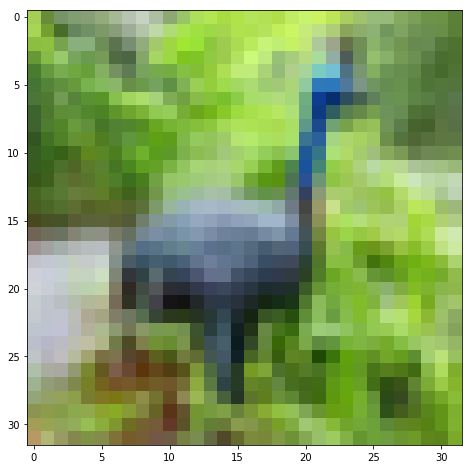

In [11]:
print(f'Класс: {classes[y]}')
imshow(x, figsize=(8, 8))

In [12]:
# таким образом мы можем итерироваться по данным
for x, y in train_loader:
    break

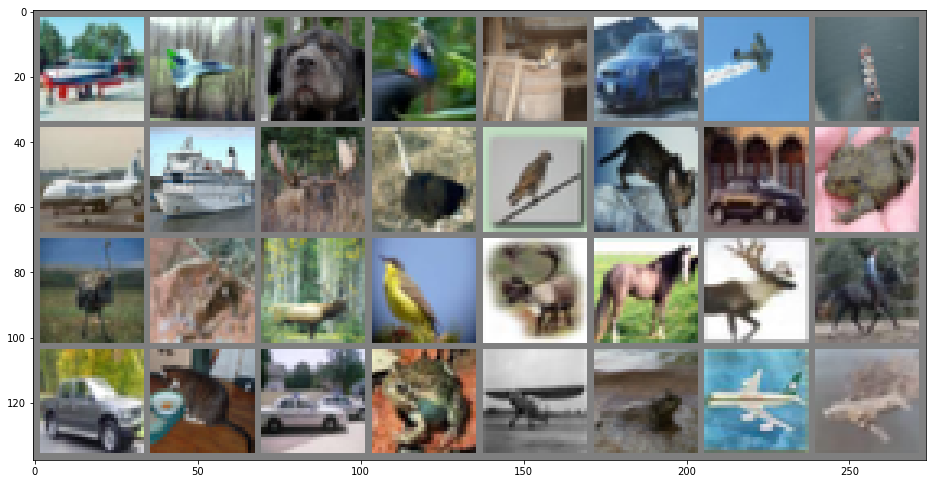

Классы: plane, plane, dog, bird, cat, car, plane, ship, plane, ship, deer, bird, bird, cat, car, frog, bird, frog, deer, bird, deer, horse, deer, horse, car, cat, car, frog, plane, frog, plane, plane


In [13]:
imshow(torchvision.utils.make_grid(x), figsize=(16, 16))
print(f'Классы: {", ".join([classes[label] for label in y])}')

In [14]:
# таким образом мы можем итерироваться по данным

progress_bar = tqdm(total=len(train_dataset), desc='Итерируемся батчами по датасету')

for x, y in train_loader:
    
    progress_bar.update(x.shape[0])
    
progress_bar.close()

Итерируемся батчами по датасету: 100%|██████████| 50000/50000 [00:04<00:00, 11953.27it/s]


In [15]:
x.shape

torch.Size([16, 3, 32, 32])

In [16]:
# почему 16, хотя батч сайз равен 32?
# потому что количество наших данных нацело не делится на 32
# и поэтому последний батч меньше 32-х
len(train_dataset) % 32

16

## Основной способ задать модель в торче

In [17]:
# наследуемся от класса torch.nn.Module
class NeuralNet(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.conv_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pooling = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.linear_1 = torch.nn.Linear(in_features=400, out_features=128)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=len(classes))
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # то как нужно преобразовать входные данные через сеть
        x = self.conv_1(x)
        x = torch.relu(x)
        x = self.pooling(x)
        
        x = self.conv_2(x)
        x = torch.relu(x)
        x = self.pooling(x)
        
        x = x.view(-1, 16 * 5 * 5)
        
        x = self.linear_1(x)
        x = torch.relu(x)
        
        x = self.linear_2(x)
        x = torch.log_softmax(x, dim=1)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [18]:
# определяем нашу модель
model = NeuralNet()

In [19]:
model

NeuralNet(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear_1): Linear(in_features=400, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
# проверим корректность
# with torch.no_grad(): позволяет не запоминать входы для расчета градиентов
with torch.no_grad():
    pred = model(x)

In [21]:
pred.shape

torch.Size([16, 10])

In [22]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.NLLLoss()

In [23]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [24]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())

for p in params:
    print(p.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([128, 400])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [25]:
from sklearn.metrics import f1_score

In [26]:
epochs = 7

In [27]:
loss_per_epoch = []
losses = []
metric = []

# перевести модель в режим тренировки
# относится к таким слоям как дропаут, батнч норм и тд
# так как они имеют разное поведение на трейне и предсказании
model.train()

for n_epoch in range(epochs):

    progress_bar = tqdm(total=len(train_dataset), desc=f'Epoch: {n_epoch + 1}')
    
    epoch_losses = []
    epoch_predictions = []
    epoch_targets = []

    # эта штука все еще отдает нам батчи данных
    for x, y in train_loader:

        # обновим наши градиенты
        # будем делать это каждую итерацию обучения
        # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
        # 
        # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
        # функция сохранения градиентов нужна для аккамуляции градиентов
        # например, когда нам не хватает памяти на большой батч
        # мы можем несколько раз прогнать forward на разных батчах
        # наши градиенты будут сохраняться
        # и только потом через несколько итераций forward обновить наши веса
        # таким образом у нас получается больше батч
        # 
        optimizer.zero_grad()

        # 
        # предсказание нашей модели
        # здесь торч сам сохраняет необходимую информацию
        # 
        # торч строит граф вычислений
        # то есть строит граф по тем операциям, которые вы определили в методе forward
        # 
        # то есть торч понимает, что вы сначала применили линейное преобразование
        # знает, где лежат веса для этого линейного преобразования
        # знает, что вы затем применили релу
        # затем опять линейное преобразование
        # затем сигмоиду
        # и вот таким образом торч выстроил граф
        # который нужен будет для backpropogation
        # 
        pred = model(x)

        # 
        # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
        # 
        loss = criterion(pred, y)
        
        epoch_predictions.append(pred.detach().numpy().squeeze().argmax(axis=1))
        epoch_targets.append(y.detach().numpy().squeeze())

        # 
        # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
        # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
        # передаем градиенты на следующие узлы
        # для весов сохраняет
        # 
        loss.backward()

        # 
        # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
        # 
        optimizer.step()

        # 
        # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
        # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
        # чтобы граф не строился дальше на каждой итерации обучения
        # работает для скаляров
        # 
        # для тензоров работает метод .tolist()
        # 
        current_loss_value = loss.item()
        epoch_losses.append(loss.item())
        
        progress_bar.update(x.shape[0])
        progress_bar.set_postfix(loss=np.mean(epoch_losses[-500:]))
        
    progress_bar.close()

    epoch_predictions = np.concatenate(epoch_predictions)
    epoch_targets = np.concatenate(epoch_targets)

    metric.append(f1_score(y_true=epoch_targets, y_pred=epoch_predictions, average='micro'))

    losses.extend(epoch_losses)
    loss_per_epoch.append(np.mean(epoch_losses))

Epoch: 7: 100%|██████████| 50000/50000 [00:13<00:00, 3684.12it/s, loss=0.945]


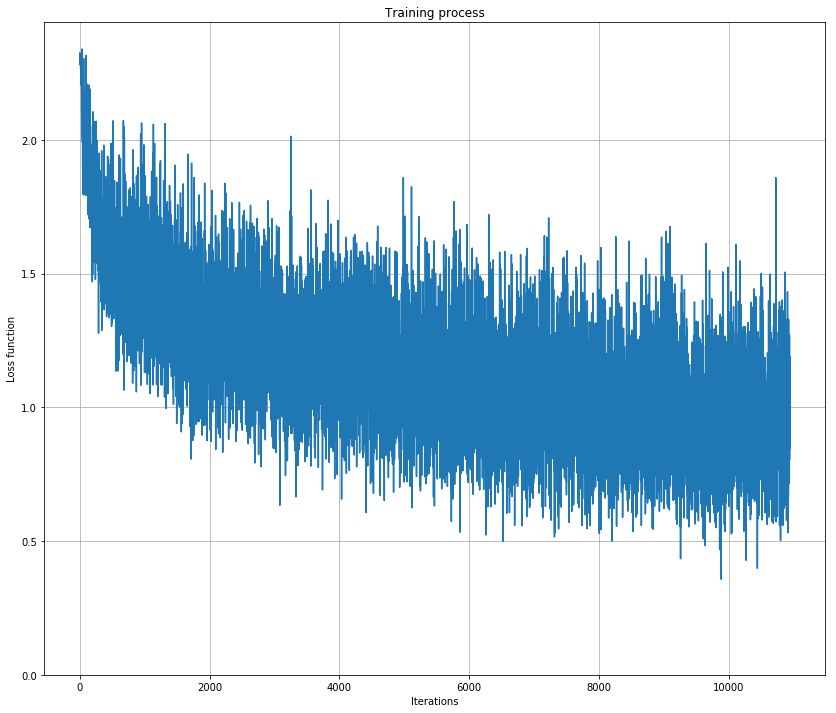

In [28]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.ylim(0);

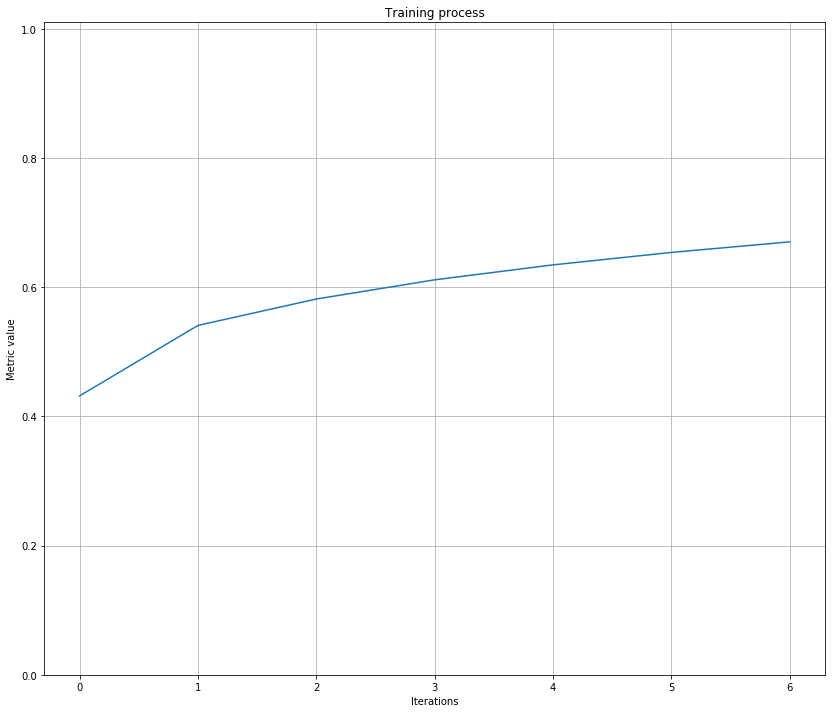

In [29]:
plt.figure(figsize=(14, 12))
plt.plot(metric, label='f1')
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Metric value')
plt.ylim(0, 1.01);

In [30]:
f'Train loss: {loss_per_epoch[-1]:.3f} | f1: {metric[-1]:.2f}'

'Train loss: 0.936 | f1: 0.67'

# Test time

In [31]:
epoch_losses = []
epoch_predictions = []
epoch_targets = []

# перевести дропаут, батч норм в режим предсказания
# да сейчас их нет в сети, но это хорошая практика
model.eval()

for x, y in test_loader:

    # with torch.no_grad(): позволяет не запоминать входы для расчета градиентов
    with torch.no_grad():
        pred = model(x)
    
    epoch_losses.append(loss.item())

    epoch_predictions.append(pred.detach().numpy().squeeze().argmax(axis=1))
    epoch_targets.append(y.detach().numpy().squeeze())

epoch_predictions = np.concatenate(epoch_predictions)
epoch_targets = np.concatenate(epoch_targets)

test_metric = f1_score(y_true=epoch_targets, y_pred=epoch_predictions, average='micro')

epoch_losses = np.mean(epoch_losses)

f'Test loss: {epoch_losses:.3f} | f1: {test_metric:.2f}'

'Test loss: 0.925 | f1: 0.62'

# Опционально
Попробуйте:
- Изменить архитектуру сети
- Добавить early stopping
- Добавить batch norm, residual, dropout
- Добавить шедуллер
- Добавить паддинг
- Добавить [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)